In [1]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

## Setup point set
In this notebook we use 2D points as a proxy for our cells that we sample and get the average feature vectors for.

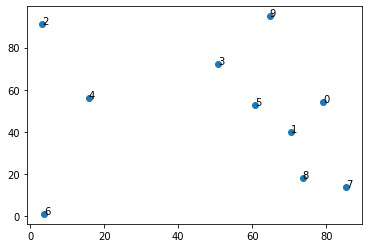

In [2]:
npoints = 10
points = np.round(np.random.random((npoints,2))*100, 2)
distances = distance.pdist(points, 'sqeuclidean').round(2)
sq_matrix_distances = distance.squareform(distances)
plt.scatter(points[:,0], points[:,1])
for i, label in enumerate(points):
    plt.annotate(i, label)


## Disimilarity using distance
We could look into using other distance metrics (*especially* in the high dimensional feature space where euclidean performs poorly).

In [3]:
np.sort(sq_matrix_distances, axis=0)[1]

array([ 278.71,  257.03, 1398.41,  475.56, 1398.41,  257.03, 3168.1 ,
        157.48,  157.48,  715.23])

In [4]:
# pointwise_dissimilarity = sq_matrix_distances.mean(axis=0)  # mean distance
# dissimilarity_ordering_idxs = np.argsort(pointwise_dissimilarity)[::-1]

pointwise_dissimilarity = np.sort(sq_matrix_distances, axis=0)[1]  # min distance 
dissimilarity_ordering_idxs = np.argsort(pointwise_dissimilarity)

print(f"Mean distance from other points:\n{pointwise_dissimilarity}")
print("Points ordered by most dissimilar: ")
print(points[dissimilarity_ordering_idxs])

Mean distance from other points:
[ 278.71  257.03 1398.41  475.56 1398.41  257.03 3168.1   157.48  157.48
  715.23]
Points ordered by most dissimilar: 
[[85.44 13.88]
 [73.59 18.01]
 [70.37 39.72]
 [60.77 52.56]
 [79.1  53.95]
 [50.81 71.96]
 [64.69 94.82]
 [ 3.18 91.26]
 [15.86 56.08]
 [ 3.67  1.13]]


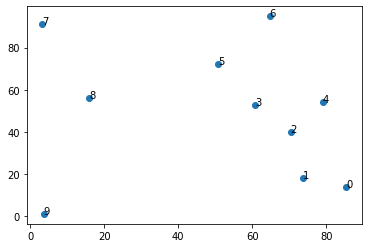

In [5]:
plt.scatter(points[:,0], points[:,1])
for i, label in enumerate (dissimilarity_ordering_idxs[:10]):
    plt.annotate(i, (points[label,0], points[label,1]))

## Clustering

In [6]:
from sklearn import cluster

### Clustering based on point coords (aka features)
Based on the features (in this case just x,y coords) we can cluster the points into groups.

In our case we would be using the 128-dimensional feature vectors (maybe including XYZ somehow, this is where Jan brings in Space2Vec, although I'm not sure its necessary).

From each cluster we could then take the sample with the highest uncertainty?

In [7]:
kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(points)

Get the most certral point in each cluster

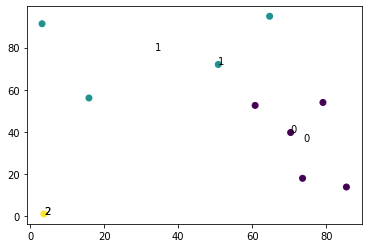

In [8]:
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)
for i, center in enumerate(kmeans.cluster_centers_):
    # get point closest to the center
    cluster_points = points[np.where(kmeans.labels_ == i)]
    closest_point = cluster_points[np.argmin(distance.cdist(cluster_points, [center], 'euclidean'))]
    plt.annotate(i, center)
    plt.annotate(i, closest_point)

#### Ranking the clusters based on variance
We give each point a random variance in this example.

Cluster variance:
[0.89 0.79 0.35]


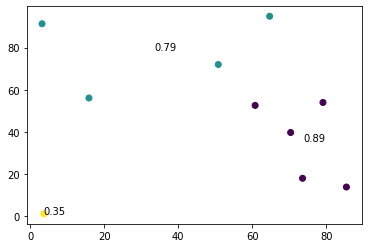

In [10]:
# Get the maximum variance of each cluster
max_cluster_variance = np.zeros(kmeans.n_clusters)
for i in range(kmeans.n_clusters):
    max_cluster_variance[i] = variance[np.where(kmeans.labels_ == i)].max().round(2)
print(f"Cluster variance:\n{max_cluster_variance}")

# Label each cluster with its max_cluster_variance
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)
for i, center in enumerate(kmeans.cluster_centers_):
    plt.annotate(max_cluster_variance[i], center)


## ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

Idx 7, Cluster 0,  variance 0.89: [85.44 13.88]
Idx 4, Cluster 1,  variance 0.79: [15.86 56.08]
Idx 8, Cluster 0,  variance 0.67: [73.59 18.01]
Idx 1, Cluster 0,  variance 0.65: [70.37 39.72]
Idx 2, Cluster 1,  variance 0.46: [ 3.18 91.26]
Idx 9, Cluster 1,  variance 0.45: [64.69 94.82]
Idx 5, Cluster 0,  variance 0.43: [60.77 52.56]
Idx 6, Cluster 2,  variance 0.35: [3.67 1.13]
Idx 0, Cluster 0,  variance 0.23: [79.1  53.95]
Idx 3, Cluster 1,  variance 0.22: [50.81 71.96]


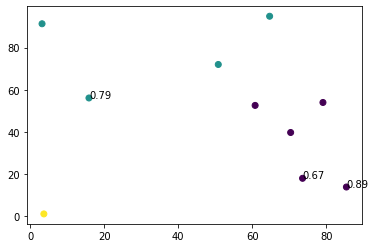

In [11]:
# plot points coloured by cluster and label the top 10 variances
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)
# Label the top 10 variances
for idx in variance_ordering_idxs[:kmeans.n_clusters]:
    plt.annotate(variance[idx].round(2), (points[idx,0], points[idx,1]))
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {variance[idx].round(2)}: {points[idx]}")

In [13]:
penalty_factor = 0.9
for i, idx in enumerate(variance_ordering_idxs):
    point = points[idx]
    current_point_cluster = kmeans.labels_[idx]
    adjustment_idxs = np.where(kmeans.labels_ == current_point_cluster)[0]
    adjustment_idxs = np.delete(adjustment_idxs, np.where(adjustment_idxs <= i))
    for x in range(i, len(variance_ordering_idxs)):
        if kmeans.labels_[x] == current_point_cluster:
            adjustment_idxs
    variance[np.where(kmeans.labels_ == current_point_cluster)] *= penalty_factor
    

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
variance_ordering_idxs = variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {variance[idx].round(2)}: {points[idx]}")
    

Old variance_ordering_idxs:
[7 4 8 1 2 9 5 6 0 3]
New variance_ordering_idxs:
[7 4 8 1 6 2 9 5 3 0]
Idx 7, Cluster 0,  variance 0.53: [85.44 13.88]
Idx 4, Cluster 1,  variance 0.52: [15.86 56.08]
Idx 8, Cluster 0,  variance 0.39: [73.59 18.01]
Idx 1, Cluster 0,  variance 0.38: [70.37 39.72]
Idx 6, Cluster 2,  variance 0.32: [3.67 1.13]
Idx 2, Cluster 1,  variance 0.3: [ 3.18 91.26]


KeyboardInterrupt: 

Cluster 2,  variance 0.54: [80.22 27.65]
Cluster 0,  variance 0.52: [90.02 54.94]
Cluster 0,  variance 0.44: [67.98 75.63]


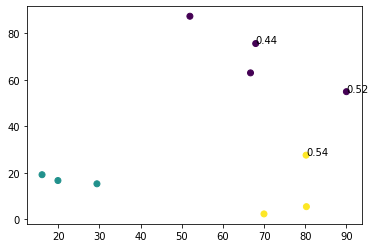

In [38]:
# plot points coloured by cluster and label the top 10 variances
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)
# Label the top 10 variances
for idx in variance_ordering_idxs[:kmeans.n_clusters]:
    plt.annotate(variance[idx].round(2), (points[idx,0], points[idx,1]))
    print(f"Cluster {kmeans.labels_[idx]},  variance {variance[idx].round(2)}: {points[idx]}")